# Expression Quantitative Trait Loci (eQTL) Analysis Tutorial

## Introduction

This comprehensive tutorial introduces **expression Quantitative Trait Loci (eQTL) analysis**, a powerful approach in statistical genetics that identifies genetic variants associated with gene expression levels. eQTL mapping bridges genotype and phenotype by revealing how DNA sequence variation influences gene regulation.

### What are eQTLs?

An **eQTL** (expression Quantitative Trait Locus) is a genomic region containing genetic variants that influence the expression level of one or more genes. eQTLs can be classified as:

- **cis-eQTLs**: Variants located near the gene they regulate (typically within 1 Mb), often affecting local regulatory elements
- **trans-eQTLs**: Variants located far from or on different chromosomes than the genes they regulate, typically acting through intermediate factors

### Tutorial Overview

This tutorial covers the complete eQTL analysis workflow:

1. **Simple SNP-Gene Expression Associations**: Understanding basic relationships between genetic variants and gene expression
2. **Handling Confounding Variation**: Incorporating covariates to control for technical and biological confounders
3. **Principal Components Analysis**: Using dimensionality reduction to capture systematic variation
4. **Genome-Wide eQTL Analysis**: Scaling up to test thousands of variant-gene pairs

### Dataset Description

We will work with simulated data containing:
- **300 individuals**
- **10 SNPs** (Single Nucleotide Polymorphisms)
- **10 genes** with expression measurements
- Genotypes encoded as 0, 1, or 2 (copies of the alternative allele)

### Prerequisites

This tutorial requires:
- Python 3.7+
- pandas, numpy, matplotlib, seaborn, scipy, scikit-learn, statsmodels
- Basic understanding of linear regression and statistical testing

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Set visualization parameters for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.1)
sns.set_palette("Set2")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("\u2713 All libraries imported successfully")
print(f"\u2713 Pandas version: {pd.__version__}")
print(f"\u2713 NumPy version: {np.__version__}")

✓ All libraries imported successfully
✓ Pandas version: 2.2.3
✓ NumPy version: 1.26.4


---
## Section 1: Simple SNP-Gene Expression Associations

In this section, we begin with fundamental eQTL concepts by examining associations between individual SNPs and gene expression levels. We will:

1. Load and explore genotype and expression data
2. Calculate Minor Allele Frequencies (MAF)
3. Visualize expression patterns across genotype groups
4. Perform linear regression to quantify SNP effects

### Learning Objectives
- Understand the structure of eQTL data
- Interpret genotype encoding (0, 1, 2)
- Visualize genotype-expression relationships
- Estimate effect sizes with confidence intervals

### 1.1 Loading and Exploring the Data

In [2]:
# Load genotype data
# Each row represents an individual, columns represent SNPs
# Values: 0 (homozygous reference), 1 (heterozygous), 2 (homozygous alternative)
geno = pd.read_csv('../data/simulated/sim_genotypes.tab', sep='\t')

# Load gene expression data
# Each row represents an individual, columns represent genes
# Values: log2-transformed normalized expression levels
expr = pd.read_csv('../data/simulated/sim_expression1.tab', sep='\t')

print("=" * 70)
print("GENOTYPE DATA")
print("=" * 70)
print(f"Dimensions: {geno.shape[0]} individuals × {geno.shape[1]-1} SNPs")
print(f"\nFirst 5 rows:")
print(geno.head())

print("\n" + "=" * 70)
print("EXPRESSION DATA")
print("=" * 70)
print(f"Dimensions: {expr.shape[0]} individuals × {expr.shape[1]-1} genes")
print(f"\nFirst 5 rows:")
print(expr.head())

# Verify data integrity
assert geno.shape[0] == expr.shape[0], "Sample size mismatch between genotype and expression data"
assert all(geno['sample'] == expr['sample']), "Sample IDs do not match between datasets"
print("\n\u2713 Data integrity verified: Sample IDs match across datasets")

GENOTYPE DATA
Dimensions: 300 individuals × 10 SNPs

First 5 rows:
     sample  snp_1  snp_2  snp_3  snp_4  snp_5  snp_6  snp_7  snp_8  snp_9  \
0  sample_1      0      0      0      0      1      0      0      0      2   
1  sample_2      0      0      0      0      0      0      0      0      2   
2  sample_3      0      0      0      0      0      0      0      0      1   
3  sample_4      0      0      0      0      0      0      1      1      0   
4  sample_5      0      0      0      0      0      0      0      1      0   

   snp_10  
0       2  
1       2  
2       2  
3       1  
4       1  

EXPRESSION DATA
Dimensions: 300 individuals × 10 genes

First 5 rows:
     sample  gene_1  gene_2  gene_3  gene_4  gene_5  gene_6  gene_7  gene_8  \
0  sample_1  6.0910  6.4793  6.7027  7.2605  8.1963  6.0617  6.5488  6.3166   
1  sample_2  7.4326  7.0161  7.5086  7.2960  7.8366  7.8257  7.5148  8.3592   
2  sample_3  6.9172  6.1274  6.0977  6.3250  6.0179  5.8881  6.9126  6.8309   
3  sa

### 1.2 Calculating Minor Allele Frequencies (MAF)

The **Minor Allele Frequency (MAF)** represents the frequency of the less common allele in a population. MAF is critical in genetics because:

- It determines statistical power to detect associations
- Rare variants (MAF < 0.05) require larger sample sizes
- Common variants (MAF > 0.05) are more reliably tested

**Calculation**: Since genotypes are coded as 0, 1, or 2 (allele counts), the allele frequency is simply the mean genotype divided by 2.

MINOR ALLELE FREQUENCY ANALYSIS
   SNP  Allele_Frequency    MAF Minor_Allele
 snp_1            0.0067 0.0067          Alt
 snp_2            0.0300 0.0300          Alt
 snp_3            0.0200 0.0200          Alt
 snp_4            0.0650 0.0650          Alt
 snp_5            0.0467 0.0467          Alt
 snp_6            0.1267 0.1267          Alt
 snp_7            0.1717 0.1717          Alt
 snp_8            0.2983 0.2983          Alt
 snp_9            0.3900 0.3900          Alt
snp_10            0.5117 0.4883          Ref


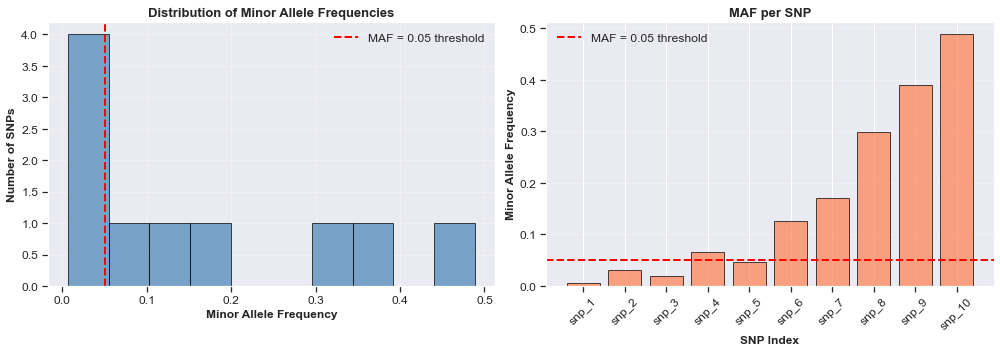


✓ MAF Statistics:
  - Mean MAF: 0.1643
  - Median MAF: 0.0958
  - Range: [0.0067, 0.4883]
  - SNPs with MAF > 0.05: 6/10


In [3]:
# Extract genotype matrix (excluding sample ID column)
geno_matrix = geno.iloc[:, 1:]

# Calculate allele frequency for each SNP
# Formula: mean(genotype) / 2, since genotypes are 0, 1, or 2
allele_freq = geno_matrix.mean() / 2

# Calculate Minor Allele Frequency (MAF)
# MAF is the minimum of allele frequency and its complement
maf = np.minimum(allele_freq, 1 - allele_freq)

# Create a summary DataFrame
maf_summary = pd.DataFrame({
    'SNP': maf.index,
    'Allele_Frequency': allele_freq.values,
    'MAF': maf.values,
    'Minor_Allele': ['Alt' if af <= 0.5 else 'Ref' for af in allele_freq.values]
})

print("=" * 70)
print("MINOR ALLELE FREQUENCY ANALYSIS")
print("=" * 70)
print(maf_summary.to_string(index=False))

# Visualize MAF distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of MAF
ax1.hist(maf.values, bins=10, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(0.05, color='red', linestyle='--', linewidth=2, label='MAF = 0.05 threshold')
ax1.set_xlabel('Minor Allele Frequency', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of SNPs', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Minor Allele Frequencies', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bar plot of MAF for each SNP
ax2.bar(range(len(maf)), maf.values, edgecolor='black', alpha=0.7, color='coral')
ax2.axhline(0.05, color='red', linestyle='--', linewidth=2, label='MAF = 0.05 threshold')
ax2.set_xlabel('SNP Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Minor Allele Frequency', fontsize=12, fontweight='bold')
ax2.set_title('MAF per SNP', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(maf)))
ax2.set_xticklabels(maf.index, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n\u2713 MAF Statistics:")
print(f"  - Mean MAF: {maf.mean():.4f}")
print(f"  - Median MAF: {maf.median():.4f}")
print(f"  - Range: [{maf.min():.4f}, {maf.max():.4f}]")
print(f"  - SNPs with MAF > 0.05: {(maf > 0.05).sum()}/{len(maf)}")

### 1.3 Visualizing Expression Levels by Genotype

Visualization is essential for eQTL discovery. Box plots and violin plots effectively show:
- Central tendency (median) of expression for each genotype group
- Variability (interquartile range) within groups
- Potential outliers
- Dose-response relationships (additive genetic effects)

We'll create a comprehensive visualization showing expression distributions across all SNP-gene combinations.

DATA TRANSFORMATION FOR VISUALIZATION
Creating plots for gene_1 across all SNPs...


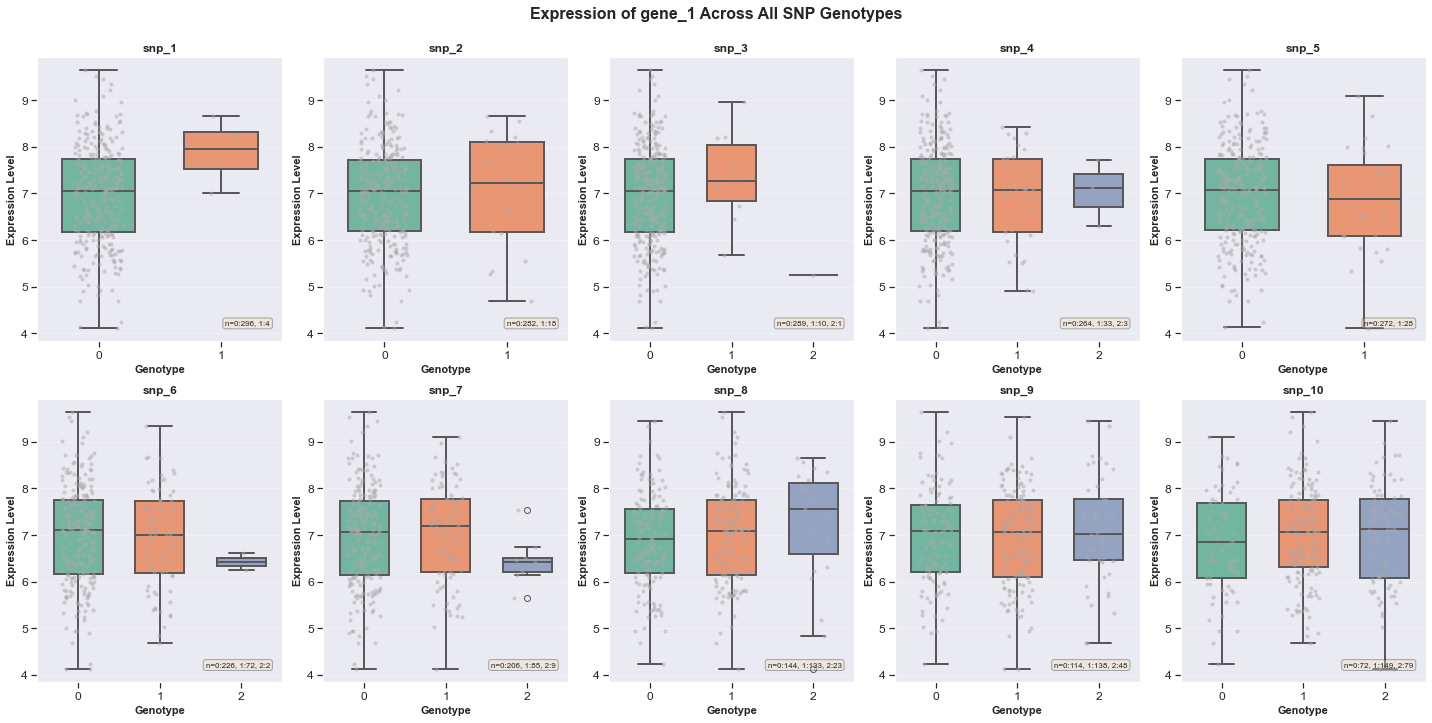


✓ Visualization complete for gene_1 across all SNPs

Interpretation Guide:
  - Box shows interquartile range (25th to 75th percentile)
  - Line in box represents median expression
  - Whiskers extend to 1.5 × IQR from quartiles
  - Individual points show actual observations
  - Sample sizes shown in bottom-right (genotype:count)
  - Look for trends: expression increasing/decreasing with genotype dosage


In [4]:
# Reshape data to long format for visualization
# This transformation allows us to plot SNP-expression relationships

# For visualization, we'll focus on one gene and show it across all SNPs
gene_to_plot = 'gene_1'

print("=" * 70)
print("DATA TRANSFORMATION FOR VISUALIZATION")
print("=" * 70)
print(f"Creating plots for {gene_to_plot} across all SNPs...")

# Set up the figure
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

# Create box plots for each SNP
for idx, snp in enumerate(geno.columns[1:]):
    ax = axes[idx]
    
    # Create a dataframe for this specific SNP-gene pair
    plot_data = pd.DataFrame({
        'genotype': geno[snp].astype('category'),
        'expression': expr[gene_to_plot]
    })
    
    # Create box plot with overlaid data points
    sns.boxplot(x='genotype', y='expression', data=plot_data, ax=ax, 
                palette='Set2', width=0.6, linewidth=2)
    
    # Add jittered points to show individual observations
    sns.stripplot(x='genotype', y='expression', data=plot_data, ax=ax,
                  color='darkgrey', alpha=0.5, size=4, jitter=0.2)
    
    ax.set_title(f'{snp}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Genotype', fontsize=11, fontweight='bold')
    ax.set_ylabel('Expression Level', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add sample size annotation
    genotype_counts = plot_data['genotype'].value_counts().sort_index()
    count_text = ', '.join([f"{g}:{c}" for g, c in genotype_counts.items()])
    ax.text(0.95, 0.05, f'n={count_text}', transform=ax.transAxes, 
            fontsize=8, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'Expression of {gene_to_plot} Across All SNP Genotypes', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n\u2713 Visualization complete for {gene_to_plot} across all SNPs")
print(f"\nInterpretation Guide:")
print(f"  - Box shows interquartile range (25th to 75th percentile)")
print(f"  - Line in box represents median expression")
print(f"  - Whiskers extend to 1.5 × IQR from quartiles")
print(f"  - Individual points show actual observations")
print(f"  - Sample sizes shown in bottom-right (genotype:count)")
print(f"  - Look for trends: expression increasing/decreasing with genotype dosage")

### 1.4 Linear Regression Analysis for SNP Effects

Linear regression is the foundation of eQTL mapping. For each SNP-gene pair, we fit the model:

$$
\text{Expression}_i = \beta_0 + \beta_1 \times \text{Genotype}_i + \epsilon_i
$$

Where:
- $\beta_0$ is the intercept (baseline expression for genotype = 0)
- $\beta_1$ is the **SNP effect** (change in expression per copy of the alternative allele)
- $\epsilon_i$ is the error term (unexplained variation)

Key metrics we extract:
- **Effect size (β)**: Magnitude of association
- **95% Confidence Interval**: Range of plausible effect sizes
- **p-value**: Statistical significance
- **R²**: Proportion of variance explained

In [5]:
def perform_eqtl_regression(genotype, expression, snp_name, gene_name):
    """
    Perform linear regression for a single SNP-gene pair.
    
    Parameters:
    -----------
    genotype : array-like
        Genotype values (0, 1, 2) for all individuals
    expression : array-like
        Expression values for all individuals
    snp_name : str
        Name of the SNP
    gene_name : str
        Name of the gene
    
    Returns:
    --------
    dict : Dictionary containing regression results
    """
    # Add intercept to the model
    X = sm.add_constant(genotype)
    y = expression
    
    # Fit linear regression model
    model = sm.OLS(y, X).fit()
    
    # Extract results
    beta = model.params[1]  # SNP effect (slope)
    se = model.bse[1]  # Standard error
    ci_lower, ci_upper = model.conf_int()[1]  # 95% confidence interval
    pval = model.pvalues[1]  # p-value
    rsquared = model.rsquared  # R-squared
    
    return {
        'SNP': snp_name,
        'Gene': gene_name,
        'Beta': beta,
        'SE': se,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper,
        'P_value': pval,
        'R_squared': rsquared
    }

# Perform regression for one SNP-gene pair as an example
example_snp = 'snp_1'
example_gene = 'gene_1'

result = perform_eqtl_regression(
    genotype=geno[example_snp].values,
    expression=expr[example_gene].values,
    snp_name=example_snp,
    gene_name=example_gene
)

print("=" * 70)
print(f"EXAMPLE eQTL REGRESSION: {example_snp} vs {example_gene}")
print("=" * 70)
print(f"Effect size (β):          {result['Beta']:.4f}")
print(f"Standard error:           {result['SE']:.4f}")
print(f"95% CI:                   [{result['CI_Lower']:.4f}, {result['CI_Upper']:.4f}]")
print(f"P-value:                  {result['P_value']:.4e}")
print(f"R² (variance explained):  {result['R_squared']:.4f}")

# Interpretation
print(f"\n{'='*70}")
print("INTERPRETATION")
print(f"{'='*70}")
if result['P_value'] < 0.05:
    direction = "increases" if result['Beta'] > 0 else "decreases"
    print(f"\u2713 SIGNIFICANT ASSOCIATION DETECTED (p < 0.05)")
    print(f"\nEach copy of the alternative allele at {example_snp}")
    print(f"{direction} expression of {example_gene} by {abs(result['Beta']):.4f} units.")
    print(f"\nThis SNP explains {result['R_squared']*100:.2f}% of variance in {example_gene} expression.")
else:
    print(f"✗ No significant association detected (p = {result['P_value']:.4f})")

# Now run regression for ALL SNP-gene pairs
print(f"\n{'='*70}")
print("COMPREHENSIVE eQTL ANALYSIS: ALL SNP-GENE PAIRS")
print(f"{'='*70}")

all_results = []
for snp in geno.columns[1:]:
    for gene in expr.columns[1:]:
        result = perform_eqtl_regression(
            genotype=geno[snp].values,
            expression=expr[gene].values,
            snp_name=snp,
            gene_name=gene
        )
        all_results.append(result)

# Convert to DataFrame
eqtl_results = pd.DataFrame(all_results)

# Add significance indicator
eqtl_results['Significant'] = eqtl_results['P_value'] < 0.05

# Sort by p-value
eqtl_results = eqtl_results.sort_values('P_value')

print(f"\nTotal tests performed: {len(eqtl_results)}")
print(f"Significant associations (p < 0.05): {eqtl_results['Significant'].sum()}")
print(f"\nTop 10 most significant associations:\n")
print(eqtl_results.head(10).to_string(index=False))

EXAMPLE eQTL REGRESSION: snp_1 vs gene_1
Effect size (β):          0.9417
Standard error:           0.5315
95% CI:                   [-0.1043, 1.9877]
P-value:                  7.7468e-02
R² (variance explained):  0.0104

INTERPRETATION
✗ No significant association detected (p = 0.0775)

COMPREHENSIVE eQTL ANALYSIS: ALL SNP-GENE PAIRS

Total tests performed: 100
Significant associations (p < 0.05): 12

Top 10 most significant associations:

   SNP    Gene   Beta     SE  CI_Lower  CI_Upper    P_value  R_squared  Significant
snp_10 gene_10 1.6163 0.0879    1.4433    1.7892 5.1877e-51     0.5317         True
 snp_9  gene_9 1.6039 0.0900    1.4267    1.7810 7.7636e-49     0.5157         True
 snp_8  gene_8 1.6050 0.0978    1.4126    1.7974 1.3613e-43     0.4750         True
 snp_7  gene_7 1.5107 0.1139    1.2865    1.7349 7.4411e-32     0.3710         True
 snp_6  gene_6 1.2928 0.1355    1.0262    1.5595 5.2610e-19     0.2340         True
 snp_4  gene_4 1.5005 0.1748    1.1564    1.8446 5.

### 1.5 Visualizing Regression Results

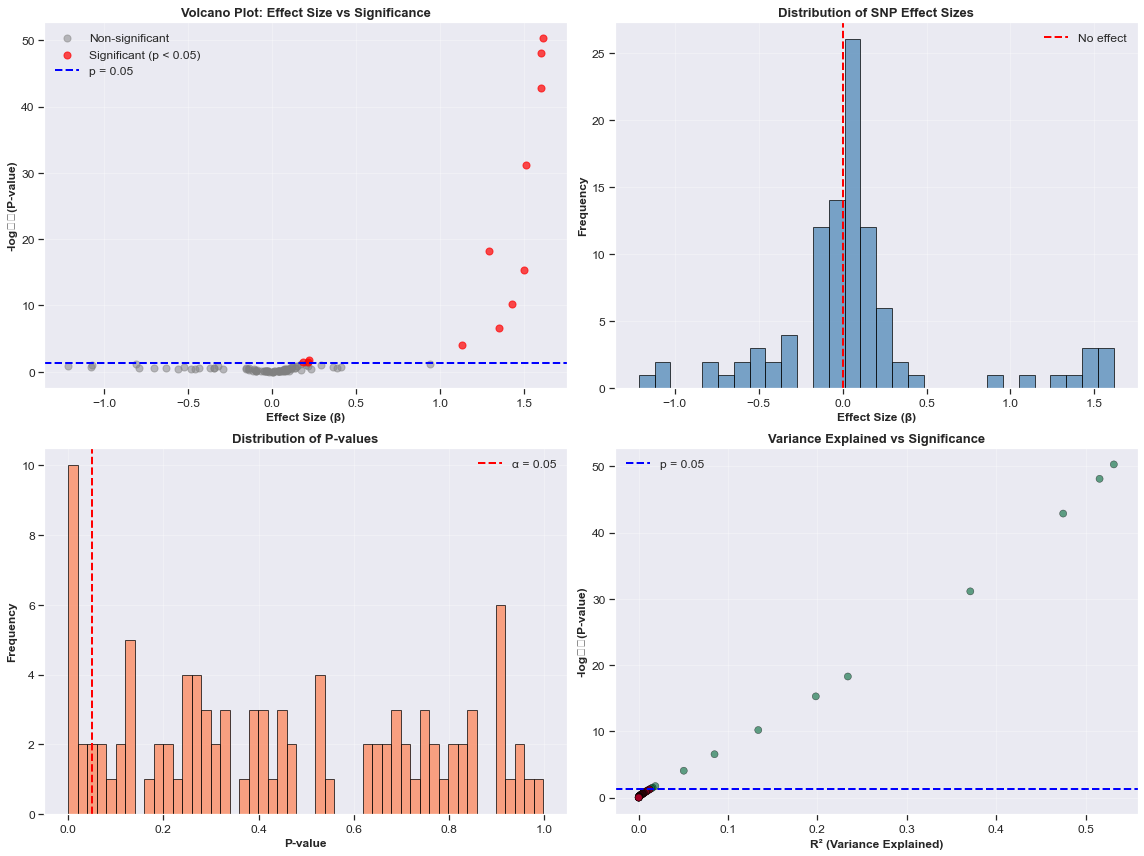


✓ Comprehensive regression analysis complete


In [6]:
# Create a comprehensive visualization of regression results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Volcano plot: Effect size vs -log10(p-value)
ax1 = axes[0, 0]
significant = eqtl_results['P_value'] < 0.05
ax1.scatter(eqtl_results.loc[~significant, 'Beta'], 
           -np.log10(eqtl_results.loc[~significant, 'P_value']),
           alpha=0.5, s=50, c='gray', label='Non-significant')
ax1.scatter(eqtl_results.loc[significant, 'Beta'], 
           -np.log10(eqtl_results.loc[significant, 'P_value']),
           alpha=0.7, s=50, c='red', label='Significant (p < 0.05)')
ax1.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=2, label='p = 0.05')
ax1.set_xlabel('Effect Size (β)', fontsize=12, fontweight='bold')
ax1.set_ylabel('-log₁₀(P-value)', fontsize=12, fontweight='bold')
ax1.set_title('Volcano Plot: Effect Size vs Significance', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribution of effect sizes
ax2 = axes[0, 1]
ax2.hist(eqtl_results['Beta'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='No effect')
ax2.set_xlabel('Effect Size (β)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of SNP Effect Sizes', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. P-value distribution
ax3 = axes[1, 0]
ax3.hist(eqtl_results['P_value'], bins=50, edgecolor='black', alpha=0.7, color='coral')
ax3.axvline(0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
ax3.set_xlabel('P-value', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Distribution of P-values', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. R-squared vs p-value
ax4 = axes[1, 1]
scatter = ax4.scatter(eqtl_results['R_squared'], 
                     -np.log10(eqtl_results['P_value']),
                     c=eqtl_results['Significant'], 
                     cmap='RdYlGn', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax4.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=2, label='p = 0.05')
ax4.set_xlabel('R² (Variance Explained)', fontsize=12, fontweight='bold')
ax4.set_ylabel('-log₁₀(P-value)', fontsize=12, fontweight='bold')
ax4.set_title('Variance Explained vs Significance', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n\u2713 Comprehensive regression analysis complete")

---
## Section 2: Handling Confounding Variation

In real-world eQTL studies, gene expression is influenced by many factors beyond genetic variation:

- **Technical confounders**: Batch effects, RNA quality, sequencing depth
- **Biological confounders**: Age, sex, cell type composition
- **Environmental factors**: Temperature, time of day, stress

Failing to account for these factors can lead to:
- **Spurious associations** (false positives)
- **Masked true associations** (false negatives)
- **Biased effect size estimates**

### Approach: Multiple Linear Regression

We extend our model to include covariates:

$$
\text{Expression}_i = \beta_0 + \beta_1 \times \text{Genotype}_i + \sum_{j=1}^{p} \gamma_j \times \text{Covariate}_{ij} + \epsilon_i
$$

This allows us to estimate the SNP effect while controlling for other sources of variation.

### 2.1 Loading and Exploring Covariates

COVARIATE DATA
Dimensions: 300 individuals × 20 covariates

First 5 rows:
     sample   var_1   var_2   var_3   var_4   var_5   var_6   var_7   var_8  \
0  sample_1  0.1805  0.6573  2.1202  0.7086  0.2261 -1.3234  0.0693 -1.2701   
1  sample_2  0.7847  1.0363  0.3572  0.8541 -0.3857  1.0154  0.9291  0.7902   
2  sample_3 -1.3532 -0.0427  0.4329  0.1914 -1.0723  0.1656 -0.9195 -0.1478   
3  sample_4  1.9833  0.2934 -0.4683 -0.6098  0.2441  0.7298  0.0270  1.0074   
4  sample_5  1.2385 -0.4435 -1.1952 -0.4784 -0.5125 -0.7493  1.4489  0.2526   

    var_9  var_10  var_11  var_12  var_13  var_14  var_15  var_16  var_17  \
0  1.9315  0.1893 -0.0258  1.4651 -1.7310 -0.8570  0.3502 -0.5500  0.5100   
1  0.7505  0.1567  0.4678  0.4504  0.2793 -0.4621  0.8739 -0.9148  1.0458   
2 -2.5731  0.2177  0.2625  0.4896  1.1094  0.1781 -0.7811  0.4241 -0.4224   
3  0.6103  0.8732  0.5287 -1.6207  0.8313  0.6226  1.3791 -0.3610 -0.1861   
4  0.0223  0.4728  0.7178 -0.2378  0.4364  1.2200 -0.2768 -1.0342 

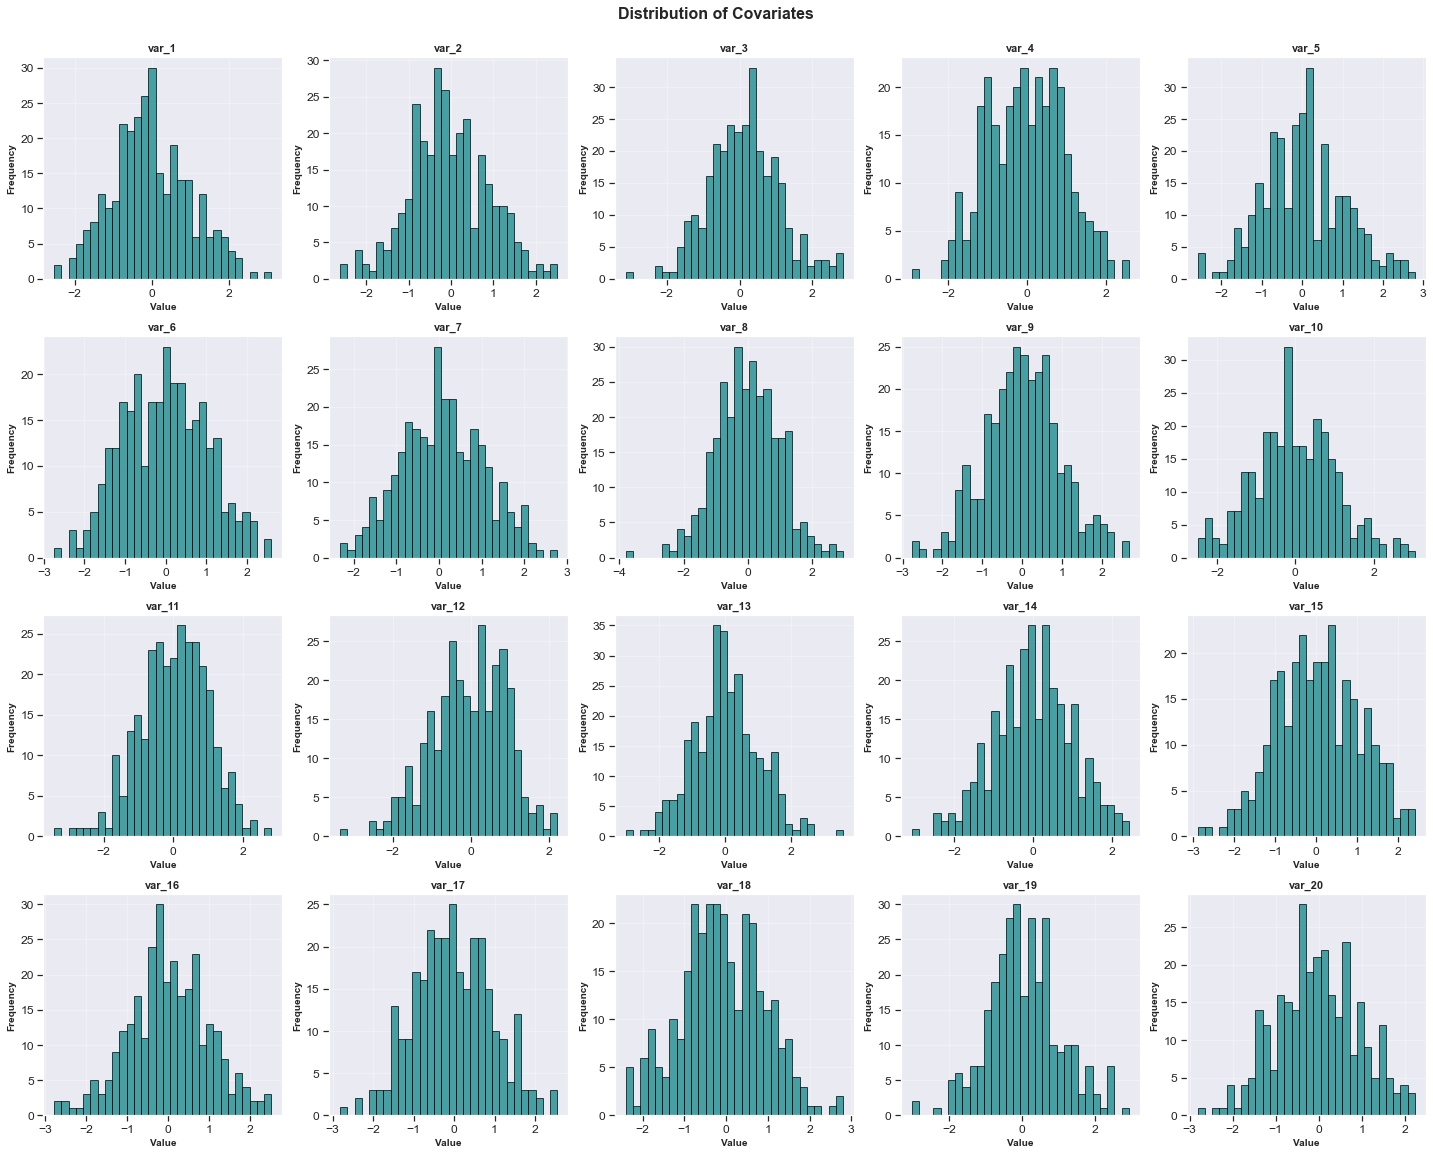


✓ Covariate data loaded and visualized successfully


In [7]:
# Load covariate data
covariates = pd.read_csv('../data/simulated/sim_covariates.tab', sep='\t')

print("=" * 70)
print("COVARIATE DATA")
print("=" * 70)
print(f"Dimensions: {covariates.shape[0]} individuals × {covariates.shape[1]-1} covariates")
print(f"\nFirst 5 rows:")
print(covariates.head())

# Examine covariate statistics
print(f"\n{'='*70}")
print("COVARIATE SUMMARY STATISTICS")
print(f"{'='*70}")
print(covariates.iloc[:, 1:].describe())

# Visualize covariate distributions
n_covariates = covariates.shape[1] - 1
n_cols = 5
n_rows = (n_covariates + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(covariates.columns[1:]):
    ax = axes[idx]
    ax.hist(covariates[col], bins=30, edgecolor='black', alpha=0.7, color='teal')
    ax.set_xlabel('Value', fontsize=10, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_covariates, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribution of Covariates', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n\u2713 Covariate data loaded and visualized successfully")

### 2.2 Regression With and Without Covariates

We will compare two models:

1. **Simple model**: Expression ~ Genotype
2. **Full model**: Expression ~ Genotype + Covariates

This comparison reveals:
- How covariates affect effect size estimates
- Changes in statistical significance
- Improvement in model fit (R²)

COMPARING MODELS: WITH AND WITHOUT COVARIATES

Summary:
  Simple model - Significant associations: 12
  With covariates - Significant associations: 13

Top 10 associations with covariates:

   SNP    Gene   Beta     SE  CI_Lower  CI_Upper    P_value  R_squared  Significant
snp_10 gene_10 1.6556 0.0905    1.4774    1.8337 3.8579e-50     0.5519         True
 snp_9  gene_9 1.5690 0.0913    1.3892    1.7488 5.0841e-46     0.5342         True
 snp_8  gene_8 1.5564 0.1000    1.3595    1.7532 4.7267e-40     0.4973         True
 snp_7  gene_7 1.5053 0.1153    1.2784    1.7322 6.3942e-31     0.3945         True
 snp_6  gene_6 1.2788 0.1372    1.0089    1.5488 3.0695e-18     0.2644         True
 snp_4  gene_4 1.4811 0.1786    1.1296    1.8327 4.2989e-15     0.2313         True
 snp_5  gene_5 1.4389 0.2081    1.0293    1.8484 3.0302e-11     0.1993         True
 snp_2  gene_2 1.3343 0.2611    0.8204    1.8483 5.8688e-07     0.1199         True
 snp_3  gene_3 1.1537 0.2878    0.5872    1.7202 7.799

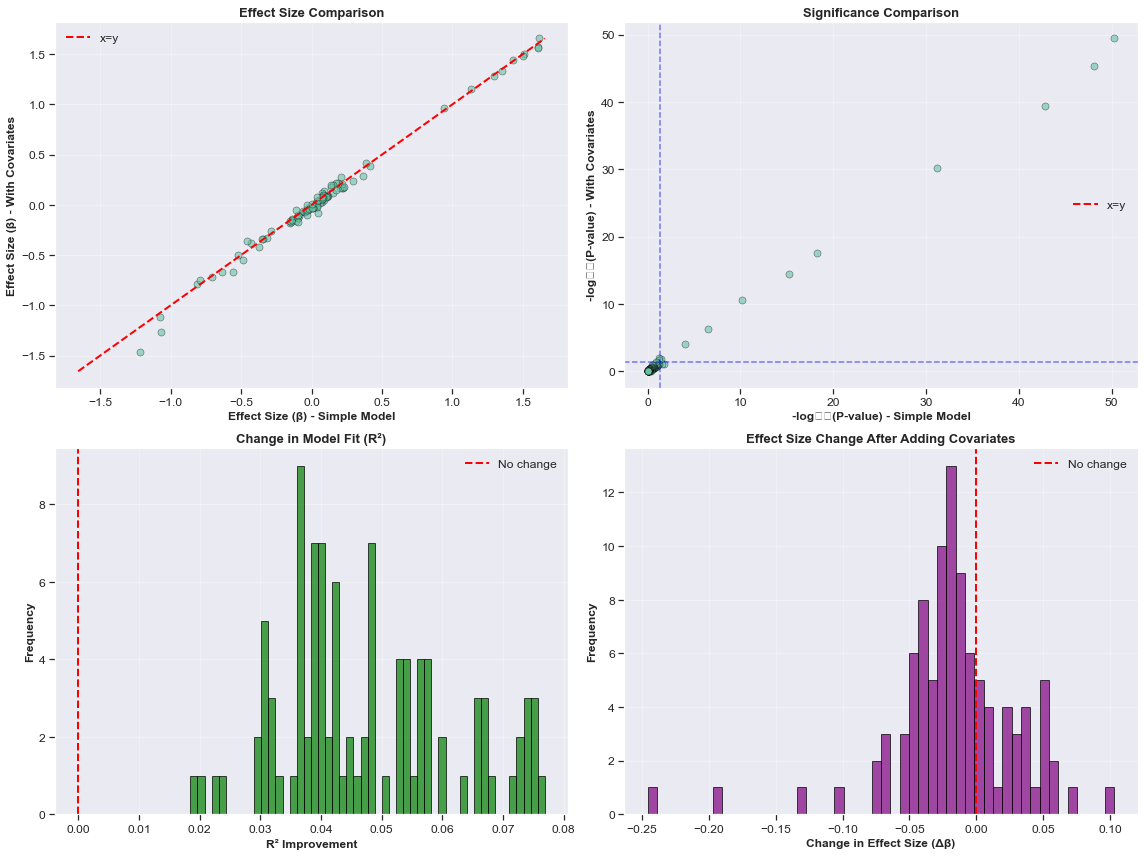


IMPACT OF COVARIATES
Mean R² improvement: 0.0474
Mean absolute beta change: 0.0361
Associations gaining significance: 3
Associations losing significance: 2

✓ Covariate analysis complete


In [8]:
def perform_eqtl_regression_with_covariates(genotype, expression, covariates_data, snp_name, gene_name):
    """
    Perform linear regression with covariates for a single SNP-gene pair.
    
    Parameters:
    -----------
    genotype : array-like
        Genotype values (0, 1, 2) for all individuals
    expression : array-like
        Expression values for all individuals
    covariates_data : DataFrame
        Covariate matrix (excluding sample ID)
    snp_name : str
        Name of the SNP
    gene_name : str
        Name of the gene
    
    Returns:
    --------
    dict : Dictionary containing regression results
    """
    # Prepare design matrix: genotype + covariates
    X = np.column_stack([genotype, covariates_data.values])
    X = sm.add_constant(X)
    y = expression
    
    # Fit linear regression model
    model = sm.OLS(y, X).fit()
    
    # Extract results (index 1 corresponds to genotype after constant)
    beta = model.params[1]
    se = model.bse[1]
    ci_lower, ci_upper = model.conf_int()[1]
    pval = model.pvalues[1]
    rsquared = model.rsquared
    
    return {
        'SNP': snp_name,
        'Gene': gene_name,
        'Beta': beta,
        'SE': se,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper,
        'P_value': pval,
        'R_squared': rsquared
    }

# Select a subset of covariates to avoid overfitting (use first 10 covariates)
covariates_subset = covariates.iloc[:, 1:11]

print("=" * 70)
print(f"COMPARING MODELS: WITH AND WITHOUT COVARIATES")
print("=" * 70)

# Run analysis for all SNP-gene pairs with covariates
all_results_with_cov = []
for snp in geno.columns[1:]:
    for gene in expr.columns[1:]:
        result = perform_eqtl_regression_with_covariates(
            genotype=geno[snp].values,
            expression=expr[gene].values,
            covariates_data=covariates_subset,
            snp_name=snp,
            gene_name=gene
        )
        all_results_with_cov.append(result)

# Convert to DataFrame
eqtl_results_with_cov = pd.DataFrame(all_results_with_cov)
eqtl_results_with_cov['Significant'] = eqtl_results_with_cov['P_value'] < 0.05
eqtl_results_with_cov = eqtl_results_with_cov.sort_values('P_value')

# Merge results for comparison
comparison = eqtl_results[['SNP', 'Gene', 'Beta', 'P_value', 'R_squared']].merge(
    eqtl_results_with_cov[['SNP', 'Gene', 'Beta', 'P_value', 'R_squared']],
    on=['SNP', 'Gene'],
    suffixes=('_simple', '_with_cov')
)

# Calculate differences
comparison['Beta_change'] = comparison['Beta_with_cov'] - comparison['Beta_simple']
comparison['Pval_change'] = comparison['P_value_with_cov'] - comparison['P_value_simple']
comparison['Rsq_improvement'] = comparison['R_squared_with_cov'] - comparison['R_squared_simple']

print(f"\nSummary:")
print(f"  Simple model - Significant associations: {eqtl_results['Significant'].sum()}")
print(f"  With covariates - Significant associations: {eqtl_results_with_cov['Significant'].sum()}")
print(f"\nTop 10 associations with covariates:\n")
print(eqtl_results_with_cov.head(10).to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Beta comparison
ax1 = axes[0, 0]
ax1.scatter(comparison['Beta_simple'], comparison['Beta_with_cov'], 
           alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
lim = max(abs(comparison['Beta_simple'].min()), abs(comparison['Beta_simple'].max()),
          abs(comparison['Beta_with_cov'].min()), abs(comparison['Beta_with_cov'].max()))
ax1.plot([-lim, lim], [-lim, lim], 'r--', linewidth=2, label='x=y')
ax1.set_xlabel('Effect Size (β) - Simple Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Effect Size (β) - With Covariates', fontsize=12, fontweight='bold')
ax1.set_title('Effect Size Comparison', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. P-value comparison
ax2 = axes[0, 1]
ax2.scatter(-np.log10(comparison['P_value_simple']), 
           -np.log10(comparison['P_value_with_cov']),
           alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
lim = max(-np.log10(comparison['P_value_simple']).max(),
          -np.log10(comparison['P_value_with_cov']).max())
ax2.plot([0, lim], [0, lim], 'r--', linewidth=2, label='x=y')
ax2.axhline(-np.log10(0.05), color='blue', linestyle='--', alpha=0.5)
ax2.axvline(-np.log10(0.05), color='blue', linestyle='--', alpha=0.5)
ax2.set_xlabel('-log₁₀(P-value) - Simple Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('-log₁₀(P-value) - With Covariates', fontsize=12, fontweight='bold')
ax2.set_title('Significance Comparison', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. R-squared improvement
ax3 = axes[1, 0]
ax3.hist(comparison['Rsq_improvement'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
ax3.set_xlabel('R² Improvement', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Change in Model Fit (R²)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Effect size change distribution
ax4 = axes[1, 1]
ax4.hist(comparison['Beta_change'], bins=50, edgecolor='black', alpha=0.7, color='purple')
ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
ax4.set_xlabel('Change in Effect Size (Δβ)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax4.set_title('Effect Size Change After Adding Covariates', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("IMPACT OF COVARIATES")
print(f"{'='*70}")
print(f"Mean R² improvement: {comparison['Rsq_improvement'].mean():.4f}")
print(f"Mean absolute beta change: {comparison['Beta_change'].abs().mean():.4f}")
print(f"Associations gaining significance: {((comparison['P_value_simple'] >= 0.05) & (comparison['P_value_with_cov'] < 0.05)).sum()}")
print(f"Associations losing significance: {((comparison['P_value_simple'] < 0.05) & (comparison['P_value_with_cov'] >= 0.05)).sum()}")
print("\n\u2713 Covariate analysis complete")

---
## Section 3: Principal Components Analysis (PCA)

**Principal Components Analysis (PCA)** is a dimensionality reduction technique that identifies major axes of variation in high-dimensional data. In eQTL studies, PCA is used to:

1. **Capture population structure** in genotype data
2. **Identify batch effects** in expression data
3. **Reduce dimensionality** of covariate space
4. **Improve power** by focusing on major sources of variation

### How PCA Works

PCA finds orthogonal directions (principal components) that maximize variance:
- **PC1**: Direction of maximum variance
- **PC2**: Direction of maximum remaining variance (orthogonal to PC1)
- And so on...

### Strategy

We will compute PCs from the covariate matrix and use the top components as covariates in our regression model.

### 3.1 Computing Principal Components

PRINCIPAL COMPONENTS ANALYSIS

PCA Results:
  - Number of components: 20
  - Total variance explained by all PCs: 1.0000

First 5 rows of principal components:
      PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8     PC9  \
0  0.4226 -1.5893 -1.6141  0.0089 -1.3664  0.8678  1.5497  1.1443 -1.0055   
1  1.5204  1.8290  0.5953 -1.4068 -0.3621  2.0319  0.1781  1.1070 -0.0775   
2 -2.3286  0.7133  1.4994 -0.5612 -0.0538  0.3743 -1.2578 -0.0384 -0.0547   
3  1.9047  0.0891  1.7136  0.9575  0.4271  1.2681 -0.2796  0.3098  0.7390   
4  2.0983  0.2903  0.2768  0.9594  0.4971 -0.5509  0.4199 -0.4888  0.5534   

     PC10    PC11    PC12    PC13    PC14    PC15    PC16    PC17    PC18  \
0  0.9968  0.0828  1.0294  0.7413  1.5214 -1.1022 -1.1303  0.6249  0.3647   
1 -1.0488 -0.0549  0.4214  0.0224 -0.2973 -1.0031 -1.3016  0.9887  0.5712   
2 -0.0412  0.6398  0.0344 -0.9334  0.1493  0.9938  0.2627  1.9211  0.4012   
3 -0.6498 -0.2852 -0.1243  0.0514 -0.9967 -0.2863 -0.1910 -1.5355  0.

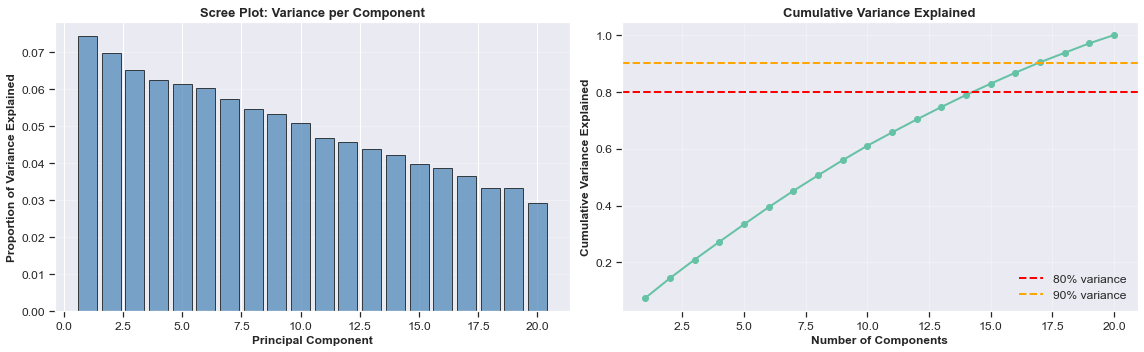


PC SELECTION
Number of PCs explaining ≥80% variance: 15
Variance explained by top 15 PCs: 0.8288

Variance per PC (top 10):
  PC1: 0.0746 (7.46%)
  PC2: 0.0697 (6.97%)
  PC3: 0.0653 (6.53%)
  PC4: 0.0626 (6.26%)
  PC5: 0.0615 (6.15%)
  PC6: 0.0603 (6.03%)
  PC7: 0.0575 (5.75%)
  PC8: 0.0546 (5.46%)
  PC9: 0.0534 (5.34%)
  PC10: 0.0508 (5.08%)

✓ PCA complete


In [9]:
print("=" * 70)
print("PRINCIPAL COMPONENTS ANALYSIS")
print("=" * 70)

# Standardize covariates (mean=0, std=1) before PCA
# This ensures all covariates contribute equally regardless of scale
scaler = StandardScaler()
covariates_scaled = scaler.fit_transform(covariates.iloc[:, 1:])

# Compute PCA
pca = PCA()
pcs = pca.fit_transform(covariates_scaled)

# Convert to DataFrame
pcs_df = pd.DataFrame(
    pcs,
    columns=[f'PC{i+1}' for i in range(pcs.shape[1])]
)

print(f"\nPCA Results:")
print(f"  - Number of components: {pcs.shape[1]}")
print(f"  - Total variance explained by all PCs: {pca.explained_variance_ratio_.sum():.4f}")
print(f"\nFirst 5 rows of principal components:")
print(pcs_df.head())

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Scree plot: Variance explained by each PC
ax1 = axes[0]
ax1.bar(range(1, min(21, len(pca.explained_variance_ratio_)+1)), 
        pca.explained_variance_ratio_[:20],
        edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
ax1.set_ylabel('Proportion of Variance Explained', fontsize=12, fontweight='bold')
ax1.set_title('Scree Plot: Variance per Component', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# 2. Cumulative variance explained
ax2 = axes[1]
cumvar = np.cumsum(pca.explained_variance_ratio_)
ax2.plot(range(1, len(cumvar)+1), cumvar, 'o-', linewidth=2, markersize=6)
ax2.axhline(0.8, color='red', linestyle='--', linewidth=2, label='80% variance')
ax2.axhline(0.9, color='orange', linestyle='--', linewidth=2, label='90% variance')
ax2.set_xlabel('Number of Components', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Variance Explained', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine number of PCs to retain (e.g., explaining 80% variance)
n_pcs = np.argmax(cumvar >= 0.8) + 1
print(f"\n{'='*70}")
print(f"PC SELECTION")
print(f"{'='*70}")
print(f"Number of PCs explaining ≥80% variance: {n_pcs}")
print(f"Variance explained by top {n_pcs} PCs: {cumvar[n_pcs-1]:.4f}")
print(f"\nVariance per PC (top 10):")
for i in range(min(10, len(pca.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({pca.explained_variance_ratio_[i]*100:.2f}%)")

print("\n\u2713 PCA complete")

### 3.2 eQTL Analysis with Principal Components

eQTL ANALYSIS WITH 10 PRINCIPAL COMPONENTS

Significant associations with PCs: 13

Top 10 associations with PCs as covariates:

   SNP    Gene   Beta     SE  CI_Lower  CI_Upper    P_value  R_squared  Significant
snp_10 gene_10 1.6593 0.0899    1.4824    1.8362 9.4186e-51     0.5534         True
 snp_9  gene_9 1.5734 0.0917    1.3929    1.7538 5.8979e-46     0.5304         True
 snp_8  gene_8 1.5650 0.0985    1.3711    1.7588 2.9852e-41     0.5009         True
 snp_7  gene_7 1.5072 0.1145    1.2818    1.7327 2.7481e-31     0.3985         True
 snp_6  gene_6 1.2973 0.1372    1.0273    1.5674 1.1721e-18     0.2642         True
 snp_4  gene_4 1.4788 0.1797    1.1251    1.8326 6.6383e-15     0.2217         True
 snp_5  gene_5 1.4609 0.2105    1.0466    1.8753 2.6068e-11     0.1840         True
 snp_2  gene_2 1.3641 0.2603    0.8518    1.8764 3.0907e-07     0.1274         True
 snp_3  gene_3 1.2002 0.2848    0.6397    1.7607 3.3521e-05     0.0989         True
snp_10  gene_7 0.2719 0.1101    

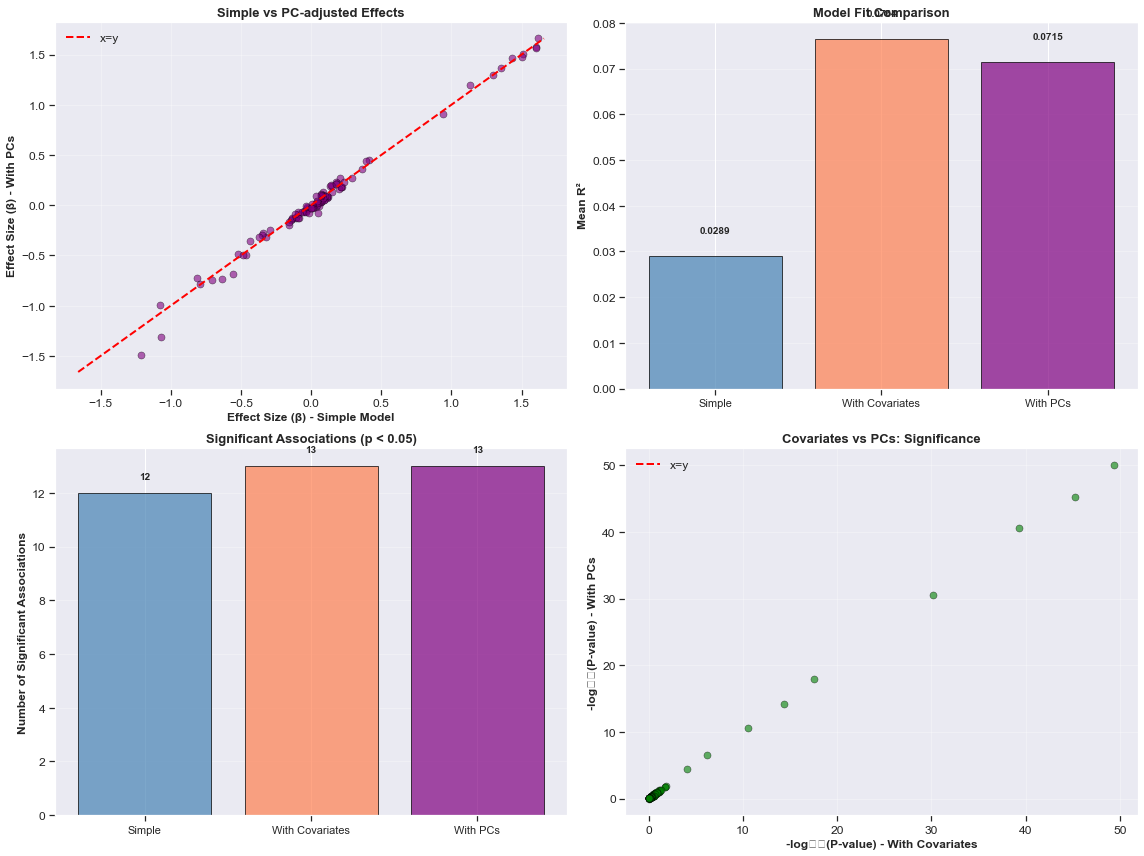


MODEL COMPARISON SUMMARY

Model                     Sig. Assoc.     Mean R²         Mean |β|       
----------------------------------------------------------------------
Simple                    12              0.0289          0.3224         
With Covariates           13              0.0764          0.3279         
With PCs                  13              0.0715          0.3284         

✓ Principal component analysis complete


In [10]:
# Select top PCs as covariates
n_pcs_to_use = 10  # Use top 10 PCs
pcs_subset = pcs_df.iloc[:, :n_pcs_to_use]

print("=" * 70)
print(f"eQTL ANALYSIS WITH {n_pcs_to_use} PRINCIPAL COMPONENTS")
print("=" * 70)

# Run analysis with PCs as covariates
all_results_with_pcs = []
for snp in geno.columns[1:]:
    for gene in expr.columns[1:]:
        result = perform_eqtl_regression_with_covariates(
            genotype=geno[snp].values,
            expression=expr[gene].values,
            covariates_data=pcs_subset,
            snp_name=snp,
            gene_name=gene
        )
        all_results_with_pcs.append(result)

# Convert to DataFrame
eqtl_results_with_pcs = pd.DataFrame(all_results_with_pcs)
eqtl_results_with_pcs['Significant'] = eqtl_results_with_pcs['P_value'] < 0.05
eqtl_results_with_pcs = eqtl_results_with_pcs.sort_values('P_value')

print(f"\nSignificant associations with PCs: {eqtl_results_with_pcs['Significant'].sum()}")
print(f"\nTop 10 associations with PCs as covariates:\n")
print(eqtl_results_with_pcs.head(10).to_string(index=False))

# Compare three models: simple, with covariates, with PCs
comparison_all = eqtl_results[['SNP', 'Gene', 'Beta', 'P_value', 'R_squared']].merge(
    eqtl_results_with_cov[['SNP', 'Gene', 'Beta', 'P_value', 'R_squared']],
    on=['SNP', 'Gene'],
    suffixes=('_simple', '_cov')
).merge(
    eqtl_results_with_pcs[['SNP', 'Gene', 'Beta', 'P_value', 'R_squared']],
    on=['SNP', 'Gene']
)
comparison_all.rename(columns={'Beta': 'Beta_pcs', 'P_value': 'P_value_pcs', 'R_squared': 'R_squared_pcs'}, inplace=True)

# Visualize three-way comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Beta comparison: Simple vs PCs
ax1 = axes[0, 0]
ax1.scatter(comparison_all['Beta_simple'], comparison_all['Beta_pcs'], 
           alpha=0.6, s=50, edgecolors='black', linewidth=0.5, color='purple')
lim = max(abs(comparison_all['Beta_simple']).max(), abs(comparison_all['Beta_pcs']).max())
ax1.plot([-lim, lim], [-lim, lim], 'r--', linewidth=2, label='x=y')
ax1.set_xlabel('Effect Size (β) - Simple Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Effect Size (β) - With PCs', fontsize=12, fontweight='bold')
ax1.set_title('Simple vs PC-adjusted Effects', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. R-squared comparison across three models
ax2 = axes[0, 1]
x_pos = np.arange(3)
rsq_means = [
    comparison_all['R_squared_simple'].mean(),
    comparison_all['R_squared_cov'].mean(),
    comparison_all['R_squared_pcs'].mean()
]
ax2.bar(x_pos, rsq_means, edgecolor='black', alpha=0.7, 
        color=['steelblue', 'coral', 'purple'])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Simple', 'With Covariates', 'With PCs'], fontsize=11)
ax2.set_ylabel('Mean R²', fontsize=12, fontweight='bold')
ax2.set_title('Model Fit Comparison', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rsq_means):
    ax2.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# 3. Significant associations across three models
ax3 = axes[1, 0]
sig_counts = [
    eqtl_results['Significant'].sum(),
    eqtl_results_with_cov['Significant'].sum(),
    eqtl_results_with_pcs['Significant'].sum()
]
ax3.bar(x_pos, sig_counts, edgecolor='black', alpha=0.7,
        color=['steelblue', 'coral', 'purple'])
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['Simple', 'With Covariates', 'With PCs'], fontsize=11)
ax3.set_ylabel('Number of Significant Associations', fontsize=12, fontweight='bold')
ax3.set_title('Significant Associations (p < 0.05)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(sig_counts):
    ax3.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 4. P-value comparison: Covariates vs PCs
ax4 = axes[1, 1]
ax4.scatter(-np.log10(comparison_all['P_value_cov']), 
           -np.log10(comparison_all['P_value_pcs']),
           alpha=0.6, s=50, edgecolors='black', linewidth=0.5, color='green')
lim = max(-np.log10(comparison_all['P_value_cov']).max(),
          -np.log10(comparison_all['P_value_pcs']).max())
ax4.plot([0, lim], [0, lim], 'r--', linewidth=2, label='x=y')
ax4.set_xlabel('-log₁₀(P-value) - With Covariates', fontsize=12, fontweight='bold')
ax4.set_ylabel('-log₁₀(P-value) - With PCs', fontsize=12, fontweight='bold')
ax4.set_title('Covariates vs PCs: Significance', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*70}")
print(f"\n{'Model':<25} {'Sig. Assoc.':<15} {'Mean R²':<15} {'Mean |β|':<15}")
print("-" * 70)
print(f"{'Simple':<25} {sig_counts[0]:<15} {rsq_means[0]:<15.4f} {comparison_all['Beta_simple'].abs().mean():<15.4f}")
print(f"{'With Covariates':<25} {sig_counts[1]:<15} {rsq_means[1]:<15.4f} {comparison_all['Beta_cov'].abs().mean():<15.4f}")
print(f"{'With PCs':<25} {sig_counts[2]:<15} {rsq_means[2]:<15.4f} {comparison_all['Beta_pcs'].abs().mean():<15.4f}")

print("\n\u2713 Principal component analysis complete")

---
## Section 4: Genome-Wide eQTL Analysis

In genome-wide eQTL studies, we test:
- **Thousands to millions of SNPs**
- **Tens of thousands of genes**
- **Billions of SNP-gene pairs**

This scale introduces several challenges:

### 4.1 Multiple Testing Problem

When performing many tests, we expect false positives by chance:
- At α = 0.05, we expect 5% false positives
- With 1,000,000 tests, that's 50,000 false positives!

**Solution**: Adjust p-values for multiple testing:
- **Bonferroni correction**: Divide α by number of tests (conservative)
- **FDR (False Discovery Rate)**: Control proportion of false discoveries (less conservative)

### 4.2 Computational Efficiency

Linear regression for millions of tests requires optimization:
- Matrix operations instead of loops
- Efficient data structures
- Parallel processing

In this section, we'll perform a comprehensive analysis of all SNP-gene pairs and apply multiple testing corrections.

### 4.1 Comprehensive eQTL Mapping with Multiple Testing Correction

In [11]:
print("=" * 70)
print("GENOME-WIDE eQTL ANALYSIS WITH MULTIPLE TESTING CORRECTION")
print("=" * 70)

# Use the best model from previous analysis (with PCs)
results_final = eqtl_results_with_pcs.copy()

# Apply multiple testing corrections
# 1. Bonferroni correction
bonferroni_threshold = 0.05 / len(results_final)
results_final['Bonferroni_significant'] = results_final['P_value'] < bonferroni_threshold

# 2. FDR correction (Benjamini-Hochberg)
_, pvals_fdr, _, _ = multipletests(results_final['P_value'], alpha=0.05, method='fdr_bh')
results_final['P_value_FDR'] = pvals_fdr
results_final['FDR_significant'] = results_final['P_value_FDR'] < 0.05

print(f"\nMultiple Testing Results:")
print(f"  - Total tests performed: {len(results_final):,}")
print(f"  - Bonferroni threshold (α=0.05): {bonferroni_threshold:.2e}")
print(f"  - Nominal significant (p < 0.05): {results_final['Significant'].sum()}")
print(f"  - Bonferroni significant: {results_final['Bonferroni_significant'].sum()}")
print(f"  - FDR significant (q < 0.05): {results_final['FDR_significant'].sum()}")

# Sort by FDR-adjusted p-value
results_final = results_final.sort_values('P_value_FDR')

print(f"\n{'='*70}")
print("TOP 15 SIGNIFICANT eQTLs (FDR < 0.05)")
print(f"{'='*70}\n")
top_eqtls = results_final[results_final['FDR_significant']].head(15)
if len(top_eqtls) > 0:
    print(top_eqtls[['SNP', 'Gene', 'Beta', 'CI_Lower', 'CI_Upper', 'P_value', 'P_value_FDR', 'R_squared']].to_string(index=False))
else:
    print("No associations pass FDR threshold.")
    print("\nTop 10 associations by nominal p-value:")
    print(results_final[['SNP', 'Gene', 'Beta', 'P_value', 'P_value_FDR', 'R_squared']].head(10).to_string(index=False))

GENOME-WIDE eQTL ANALYSIS WITH MULTIPLE TESTING CORRECTION

Multiple Testing Results:
  - Total tests performed: 100
  - Bonferroni threshold (α=0.05): 5.00e-04
  - Nominal significant (p < 0.05): 13
  - Bonferroni significant: 9
  - FDR significant (q < 0.05): 9

TOP 15 SIGNIFICANT eQTLs (FDR < 0.05)

   SNP    Gene   Beta  CI_Lower  CI_Upper    P_value  P_value_FDR  R_squared
snp_10 gene_10 1.6593    1.4824    1.8362 9.4186e-51   9.4186e-49     0.5534
 snp_9  gene_9 1.5734    1.3929    1.7538 5.8979e-46   2.9489e-44     0.5304
 snp_8  gene_8 1.5650    1.3711    1.7588 2.9852e-41   9.9507e-40     0.5009
 snp_7  gene_7 1.5072    1.2818    1.7327 2.7481e-31   6.8702e-30     0.3985
 snp_6  gene_6 1.2973    1.0273    1.5674 1.1721e-18   2.3442e-17     0.2642
 snp_4  gene_4 1.4788    1.1251    1.8326 6.6383e-15   1.1064e-13     0.2217
 snp_5  gene_5 1.4609    1.0466    1.8753 2.6068e-11   3.7240e-10     0.1840
 snp_2  gene_2 1.3641    0.8518    1.8764 3.0907e-07   3.8634e-06     0.1274
 sn

### 4.2 Manhattan Plot: Genome-Wide Visualization

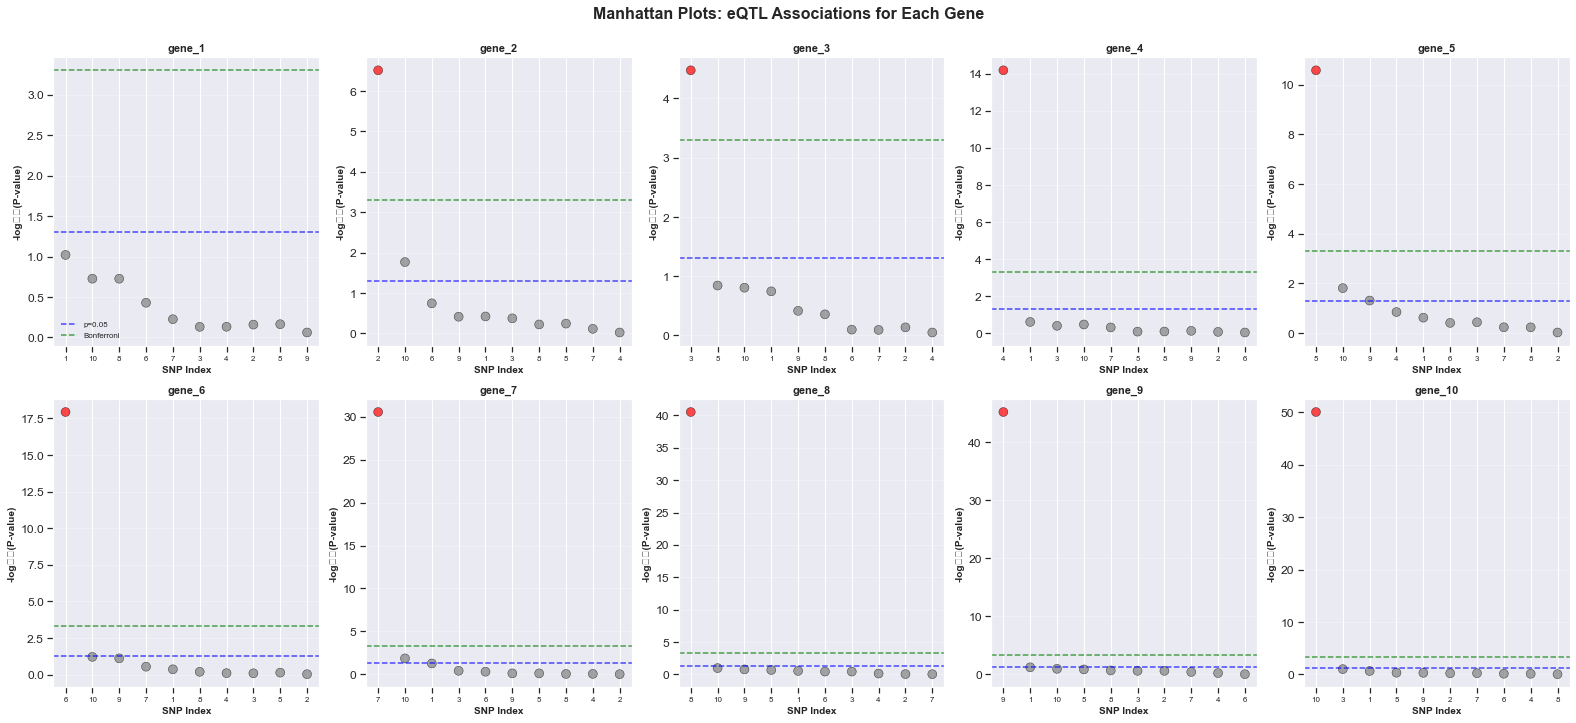


✓ Manhattan plots generated


In [12]:
# Create Manhattan-style plot (one per gene)
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.flatten()

for idx, gene in enumerate(expr.columns[1:]):
    ax = axes[idx]
    gene_results = results_final[results_final['Gene'] == gene].copy()
    
    # Plot -log10(p-values)
    x = range(len(gene_results))
    y = -np.log10(gene_results['P_value'])
    
    # Color by significance
    colors = ['red' if fdr else 'gray' for fdr in gene_results['FDR_significant']]
    
    ax.scatter(x, y, c=colors, s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Add significance thresholds
    ax.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1.5, 
              alpha=0.7, label='p=0.05')
    ax.axhline(-np.log10(bonferroni_threshold), color='green', linestyle='--', 
              linewidth=1.5, alpha=0.7, label='Bonferroni')
    
    ax.set_xlabel('SNP Index', fontsize=10, fontweight='bold')
    ax.set_ylabel('-log₁₀(P-value)', fontsize=10, fontweight='bold')
    ax.set_title(f'{gene}', fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([s.split('_')[1] for s in gene_results['SNP']], fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    
    if idx == 0:
        ax.legend(fontsize=8)

plt.suptitle('Manhattan Plots: eQTL Associations for Each Gene', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n\u2713 Manhattan plots generated")

### 4.3 eQTL Effect Size Heatmap

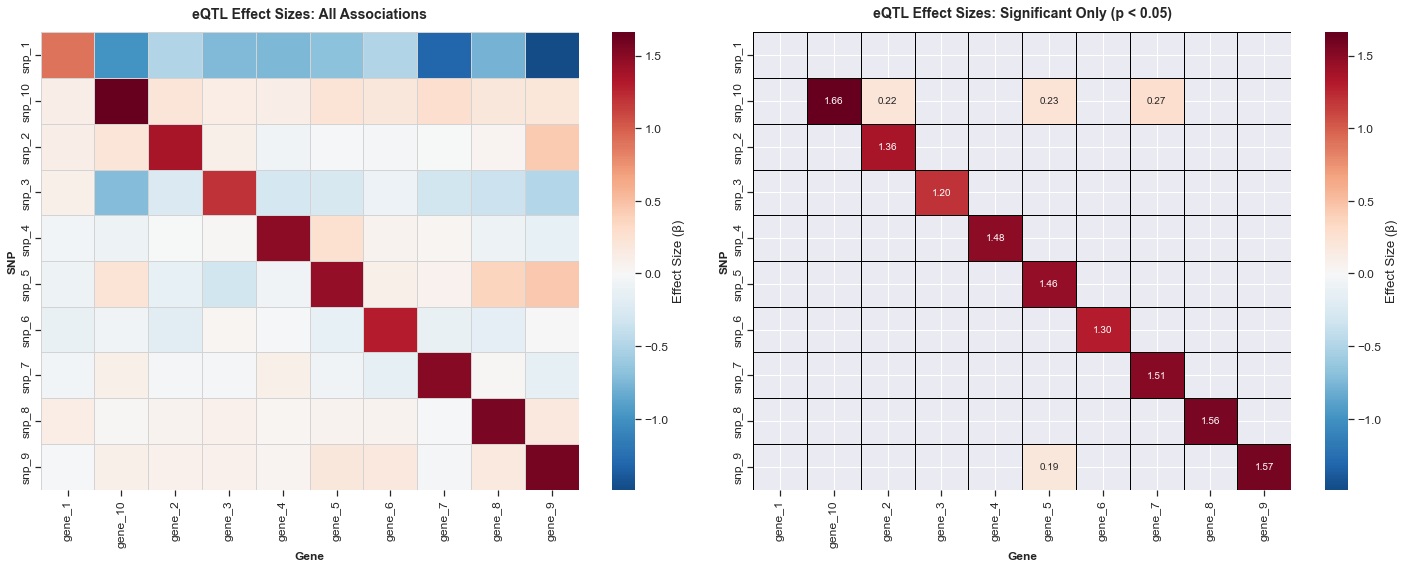


✓ eQTL effect size heatmaps generated


In [13]:
# Create effect size matrix for heatmap
effect_matrix = results_final.pivot(index='SNP', columns='Gene', values='Beta')
pval_matrix = results_final.pivot(index='SNP', columns='Gene', values='P_value')

# Create mask for non-significant associations
mask = pval_matrix > 0.05

# Create heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap 1: All effect sizes
sns.heatmap(effect_matrix, annot=False, fmt=".2f", cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Effect Size (β)'}, ax=ax1,
            linewidths=0.5, linecolor='lightgray')
ax1.set_title('eQTL Effect Sizes: All Associations', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Gene', fontsize=12, fontweight='bold')
ax1.set_ylabel('SNP', fontsize=12, fontweight='bold')

# Heatmap 2: Only significant associations
effect_matrix_masked = effect_matrix.copy()
effect_matrix_masked[mask] = np.nan
sns.heatmap(effect_matrix_masked, annot=True, fmt=".2f", cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Effect Size (β)'}, ax=ax2,
            linewidths=0.5, linecolor='black', 
            mask=mask, vmin=effect_matrix.min().min(), vmax=effect_matrix.max().max())
ax2.set_title('eQTL Effect Sizes: Significant Only (p < 0.05)', 
             fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Gene', fontsize=12, fontweight='bold')
ax2.set_ylabel('SNP', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n\u2713 eQTL effect size heatmaps generated")

### 4.4 Summary Statistics and Export Results

In [14]:
print("=" * 70)
print("FINAL SUMMARY STATISTICS")
print("=" * 70)

# Summary by gene
summary_by_gene = results_final.groupby('Gene').agg({
    'FDR_significant': 'sum',
    'P_value': 'min',
    'Beta': lambda x: x.abs().max(),
    'R_squared': 'max'
}).reset_index()
summary_by_gene.columns = ['Gene', 'N_significant_eQTLs', 'Min_pvalue', 'Max_abs_beta', 'Max_Rsquared']
summary_by_gene = summary_by_gene.sort_values('N_significant_eQTLs', ascending=False)

print("\nSummary by Gene:")
print(summary_by_gene.to_string(index=False))

# Summary by SNP
summary_by_snp = results_final.groupby('SNP').agg({
    'FDR_significant': 'sum',
    'P_value': 'min',
    'Beta': lambda x: x.abs().max(),
    'R_squared': 'max'
}).reset_index()
summary_by_snp.columns = ['SNP', 'N_genes_affected', 'Min_pvalue', 'Max_abs_beta', 'Max_Rsquared']
summary_by_snp = summary_by_snp.sort_values('N_genes_affected', ascending=False)

print("\n" + "=" * 70)
print("\nSummary by SNP:")
print(summary_by_snp.to_string(index=False))

# Overall statistics
print("\n" + "=" * 70)
print("OVERALL STATISTICS")
print("=" * 70)
print(f"Total SNP-gene pairs tested: {len(results_final):,}")
print(f"Nominally significant (p < 0.05): {results_final['Significant'].sum():,} ({results_final['Significant'].sum()/len(results_final)*100:.2f}%)")
print(f"FDR significant (q < 0.05): {results_final['FDR_significant'].sum():,} ({results_final['FDR_significant'].sum()/len(results_final)*100:.2f}%)")
print(f"Bonferroni significant: {results_final['Bonferroni_significant'].sum():,} ({results_final['Bonferroni_significant'].sum()/len(results_final)*100:.2f}%)")
print(f"\nEffect size range: [{results_final['Beta'].min():.4f}, {results_final['Beta'].max():.4f}]")
print(f"Mean |effect size|: {results_final['Beta'].abs().mean():.4f}")
print(f"Median |effect size|: {results_final['Beta'].abs().median():.4f}")
print(f"\nR² range: [{results_final['R_squared'].min():.4f}, {results_final['R_squared'].max():.4f}]")
print(f"Mean R²: {results_final['R_squared'].mean():.4f}")

# Save results to file
output_file = '../data/eqtl_results_complete.tsv'
results_final.to_csv(output_file, sep='\t', index=False)
print(f"\n\u2713 Results saved to: {output_file}")

print("\n" + "=" * 70)
print("eQTL ANALYSIS COMPLETE!")
print("=" * 70)

FINAL SUMMARY STATISTICS

Summary by Gene:
   Gene  N_significant_eQTLs  Min_pvalue  Max_abs_beta  Max_Rsquared
gene_10                    1  9.4186e-51        1.6593        0.5534
 gene_2                    1  3.0907e-07        1.3641        0.1274
 gene_3                    1  3.3521e-05        1.2002        0.0989
 gene_4                    1  6.6383e-15        1.4788        0.2217
 gene_5                    1  2.6068e-11        1.4609        0.1840
 gene_6                    1  1.1721e-18        1.2973        0.2642
 gene_7                    1  2.7481e-31        1.5072        0.3985
 gene_8                    1  2.9852e-41        1.5650        0.5009
 gene_9                    1  5.8979e-46        1.5734        0.5304
 gene_1                    0  9.5543e-02        0.9031        0.0583


Summary by SNP:
   SNP  N_genes_affected  Min_pvalue  Max_abs_beta  Max_Rsquared
snp_10                 1  9.4186e-51        1.6593        0.5534
 snp_2                 1  3.0907e-07        1.3641

---
## Conclusions and Key Takeaways

### What We Learned

1. **eQTL Fundamentals**
   - eQTLs link genetic variation to gene expression
   - Linear regression quantifies SNP effects on expression
   - Effect sizes represent change in expression per allele copy

2. **Importance of Confounders**
   - Raw expression data contains technical and biological noise
   - Covariates improve power and reduce false positives
   - PCA efficiently captures major sources of variation

3. **Multiple Testing**
   - Genome-wide studies require p-value adjustment
   - FDR methods balance sensitivity and specificity
   - Bonferroni is conservative but guarantees control

4. **Interpretation**
   - Statistical significance ≠ biological importance
   - Effect sizes and R² indicate practical relevance
   - Visualization aids interpretation and communication

### Next Steps

- **Replication**: Validate findings in independent cohorts
- **Functional Analysis**: Investigate mechanisms of top eQTLs
- **Integration**: Combine with GWAS for disease insights
- **Advanced Methods**: Explore trans-eQTLs, interaction effects, and causal inference

### Resources

- **GTEx Consortium**: [gtexportal.org](https://gtexportal.org)
- **eQTL Catalogue**: [ebi.ac.uk/eqtl](https://www.ebi.ac.uk/eqtl)
- **Tools**: MatrixEQTL, FastQTL, tensorQTL

---

**Tutorial completed successfully!** This notebook has introduced the fundamental concepts and practical methods for eQTL analysis using Python.